# Домашнее задание по теме "Извлечение информации"

# Задание 1: составить словари для классификации по тональности.

Данные для задания — отзывы на банки, собранные с нескольких сайтов рунета. Отзывы могут быть как положительными
— оценка 5, так и отрицательными — оценка 1.

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
* тест на определение ближайших слов
* тест на аналогии (мужчина — король : женщина — королева)
* тест на определение лишнего слова
4. Постройте несколько визуализаций:
* TSNE для топ-100 или топ-500 слов и найдите осмысленные кластеры слов
* задайте координаты для нового пространства следующим образом: одна ось описывает отношение «плохо — хорошо», вторая — «медленно — быстро», и найдите координаты названий банков в этих координатах

In [1]:
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import json

import bz2
import re
from tqdm import tqdm
from scipy import sparse

%matplotlib inline

In [2]:
# Очень проблематично открыть этот файл по каким-то причинам. Почему-то если он лежит в одной папке, 
# то открыть его можно, но если этот же файл положить в папку с ноутбуком, то открыть не получается, выводит
# ошибку "OSError: Invalid data stream"

responses = []

with bz2.BZ2File('/Users/glebmutovin/Data_Science/DataScience_Netology/Machine_learning/NLP/DZ_1_NLP/banki_responses.json.bz2','r') as file:
    for row in file:
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)
            

In [3]:
len(responses)

153499

In [4]:
responses[99:101]

[{'city': 'г. Саратов',
  'rating_not_checked': False,
  'title': 'Карта ко вкладу',
  'num_comments': 0,
  'bank_license': 'лицензия № 880',
  'author': 'ronnichka',
  'bank_name': 'Югра',
  'datetime': '2015-06-03 20:56:57',
  'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
  'rating_grade': 3},
 {'city': 'г. Кострома',
  'rating_not_checked': False,
  'title': 'Как быстро данные о погашении кредита передаются в БКИ?',
  'num_comments': 4,
  'bank_license': 'лицензия № 3349',
  'author': 'Natlion',
  'bank_name': 'Россельхозбанк',
  'datetime': '2015-06-03 21:29:27',
  'text': 'Здравствуйте, Уважаемые сотрудники банка! В декабре 2014 года я взяла потребите

In [29]:
# Сократим датасет

In [5]:
resp_texts = []
resp_rating = []

for resp in responses:
    if resp['city'] is not None:
        if resp['rating_grade'] is not None:
            resp_texts.append(resp['text'])
            resp_rating.append(resp['rating_grade'])
    
len(resp_texts)     

74710

In [6]:
df = pd.DataFrame({'text': resp_texts,
                   'rating': resp_rating
                  })

In [7]:
df.head(10)

,text,rating
0,"Также как и многие давний клиент банка, был до...",2
1,Открыт вклад и счет в USD. Плюс к этому есть з...,1
2,Доброго времени! Вчера мне поступило смс-уведо...,1
3,"05.06.2015г. около 15 часов, пришел в указанны...",1
4,Для оплаты коммунальных платежей пользуюсь пла...,1
5,В апреле этого года пришла в отделение сбербан...,1
6,"В продолжение истории, которая тянется с марта...",1
7,Досрочно закрывали вклады перед отпуском. Жена...,5
8,"Здравствуйте! Хотела написать, что мне месяц н...",3
9,Являюсь клиентом данного банка года с 2004 или...,1


In [8]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/glebmutovin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/glebmutovin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
noise = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 
                                      'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой']

In [11]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [12]:
from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()
    except:
        return " "

In [13]:
def process_words_review(text, tokenizer, remove_stopwords=False, stops=noise):
    regex = re.compile("[А-Яа-я]+")
    text = ' '.join(re.findall(regex, text))
    words = text.lower().split()
    if remove_stopwords:
        words = [w for w in words if w not in stops]
        
    lemmatized_words = lemmatize(" ".join(words))
    return lemmatized_words

def review_to_sentences(text, tokenizer=sentence_tokenizer, remove_stopwords=True):
    raw_sentences = tokenizer.tokenize(text.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            processed_sentence = process_words_review(raw_sentence, remove_stopwords)
            sentences.append(processed_sentence)
            
    return sentences


In [14]:
%%time 
df.text = df.text.apply(review_to_sentences)

CPU times: user 1min 38s, sys: 7.72 s, total: 1min 46s
Wall time: 10min 39s


In [18]:
'. '.join(df.text[2])

'добрый время. вчера я поступать смс уведомление о то что банк делать я эксклюзивный предложение по кредит. являться клиент банк в настоящий время но в связь с проявлять инициатива банк решать воспользоваться предложение. приезжать сегодня день в отделение заполнять анкета сразу пояснять без страховка сотрудник имя не помнить начало сразу приводить я довод об отказ в кредитование без страховка ну мы то понимать что это их зарплата я молча она выслушивать в конец еще раз пояснять без страховка поставлять соответствующий пункт в заявление на кредит. сотрудник принимать заявление и сказать мы вы позвонить и уведомлять о решение банк я уезжать вечер сотрудник я действительно перезванивать сообщать что заявка одобрять я сказать что постараться успевать успевать приезжать подходить сотрудник говорить присаживаться я приседать было чувство скрытый тревога и не зря я еще раз уточнять без страховка и тут сотрудник я уведомлять вы одобрять кредит с минимальный пакет страхование. я она еще раз по

In [16]:
# All sentences

all_sentences = []

for sentences in df.text:
    for s in sentences:
        all_sentences.append(s.split())


2. Обучите по коллекции предложений word2vec

In [19]:
from gensim.models.word2vec import Word2Vec

In [20]:
%time model_reviews = Word2Vec(all_sentences, workers=4, vector_size=300, min_count=3, window=10)

CPU times: user 4min 28s, sys: 8.52 s, total: 4min 36s
Wall time: 1min 19s


In [21]:
model_reviews.wv.init_sims()

3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:

* тест на определение ближайших слов
* тест на аналогии (мужчина — король : женщина — королева)
* тест на определение лишнего слова

In [22]:
# тест на определение ближайших слов

In [24]:
model_reviews.wv.most_similar('доллар')

[('евро', 0.8767818808555603),
 ('валюта', 0.7594707608222961),
 ('долл', 0.7339372038841248),
 ('крона', 0.7153873443603516),
 ('фунт', 0.666366696357727),
 ('рублевый', 0.6429120898246765),
 ('долларовый', 0.6251934170722961),
 ('сша', 0.6177835464477539),
 ('конвертировать', 0.6090084910392761),
 ('франк', 0.5964083075523376)]

In [25]:
model_reviews.wv.most_similar('отделение')

[('офис', 0.8273845314979553),
 ('допофис', 0.7869031429290771),
 ('филиал', 0.7575883865356445),
 ('отд', 0.7246688604354858),
 ('осб', 0.6759950518608093),
 ('оо', 0.6240938901901245),
 ('кко', 0.6106140613555908),
 ('всп', 0.5630589127540588),
 ('представительство', 0.4994811713695526),
 ('тц', 0.49362945556640625)]

In [26]:
# Не очень удачные ближайшие слова
model_reviews.wv.most_similar('телескоп')

[('селезнева', 0.828170657157898),
 ('петройл', 0.8191756010055542),
 ('титр', 0.8184131383895874),
 ('арефьев', 0.8097760081291199),
 ('трест', 0.8087880611419678),
 ('анита', 0.8070286512374878),
 ('балерика', 0.8069325685501099),
 ('абалдеть', 0.8067927360534668),
 ('таманский', 0.8043199777603149),
 ('фигасе', 0.801784873008728)]

In [94]:
# тест на аналогии (мужчина — король : женщина — королева)

In [31]:
# Совсем не те аналогии
model_reviews.wv.most_similar(positive=['сша', 'вашингтон'], negative=['россия'])[0][0]

'австралийский'

In [29]:
model_reviews.wv.most_similar(positive=['рубль', 'россия'], negative=['сша'])[0][0]

'руб'

In [30]:
model_reviews.wv.most_similar(positive=['женщина', 'сотрудник'], negative=['мужчина'])[0][0]

'работник'

In [96]:
# тест на определение лишнего слова

In [32]:
model_reviews.wv.doesnt_match('кидалово отделение ужас обман'.split())

'отделение'

In [33]:
model_reviews.wv.doesnt_match('набросок анекдот история книга'.split())

'книга'

In [34]:
# Не очень удачное определение лишнего слова - должен быть убрать США, так как остальные слова - виды валют
model_reviews.wv.doesnt_match('сша доллар евро юань'.split())

'юань'

In [35]:
model_reviews.wv

4. Постройте несколько визуализаций:

* TSNE для топ-100 или топ-500 слов и найдите осмысленные кластеры слов
* задайте координаты для нового пространства следующим образом: одна ось описывает отношение «плохо — хорошо», вторая — «медленно — быстро», и найдите координаты названий банков в этих координатах

In [36]:
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [37]:
lemmata = [lemma for text in all_sentences for lemma in text]
cnt = Counter(lemmata)

In [42]:
word_freq = [w for w in cnt.most_common(100)]

In [43]:
top_100 = [w[0] for w in word_freq]

In [44]:
w2v = pd.DataFrame(dict(zip(model_reviews.wv.index_to_key, model_reviews.wv.vectors)))

In [45]:
w2v_trans = w2v.T

In [46]:
w2v_trans.shape

(31956, 300)

In [47]:
w2v_trans.loc[top_100]

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
в,0.427229,0.198151,-0.177447,1.542318,-1.992345,1.525598,-0.394234,-0.552754,0.799115,2.259962,...,0.378902,-0.568607,-0.372738,1.308795,0.819961,-0.703281,1.244516,-0.650165,1.649097,0.378046
я,-0.761592,-0.292784,-0.867801,-2.231197,-0.424321,0.874956,-1.584360,-0.097965,0.751233,1.661515,...,-1.507162,-0.826543,-0.121987,-0.258558,-0.707958,1.335407,0.154357,1.413125,-1.421626,0.277775
и,0.384934,-2.296795,-0.957242,-0.682250,-0.275195,0.212756,-0.212683,-1.088689,-0.631496,0.869585,...,0.623142,0.286805,0.157587,-0.661658,-0.422437,0.468762,1.650657,0.260468,-0.033569,-0.480183
не,0.319584,-1.180177,-2.905649,-1.815677,-0.827871,1.458856,-0.954763,-2.870090,0.115624,-0.244875,...,-0.607312,-0.709656,-0.175207,-1.407218,0.274016,3.666088,1.137111,-0.705164,0.139342,-1.272943
на,-0.751673,0.514665,-0.069414,-0.477190,-0.623812,0.957480,-1.387638,-2.021895,1.660847,-0.231796,...,1.606735,-1.004104,-0.608138,-0.375570,-0.971035,-0.550345,1.451332,-0.223714,-0.069727,-0.627354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ни,2.584795,0.579335,0.465192,0.165147,-1.004332,0.412382,0.813057,-2.060010,0.488019,-0.706628,...,0.440966,1.853439,0.333806,1.429594,0.340770,2.705394,2.105649,0.074046,0.644584,0.055208
отвечать,1.626536,-1.419342,0.171205,-1.701722,-0.026771,2.176425,-2.828776,-3.156646,-1.963332,-0.877413,...,0.519610,-3.034960,2.157679,2.065053,-2.534783,-1.178236,0.741028,0.579159,0.170850,0.417364
или,-0.701875,-0.709831,-0.255320,-0.440416,-1.434309,-0.331671,0.722662,-1.306329,0.756182,-0.109052,...,-0.737968,-2.548599,0.163880,-0.678401,0.573863,-0.823476,-0.625647,0.853161,0.274722,-0.099252
документ,-0.444820,-2.459688,1.431132,-2.123246,1.558498,0.631513,-0.814515,-1.452090,-1.667602,1.131978,...,-1.368281,-2.919716,0.347673,-0.069625,-1.743506,-1.987788,-0.724785,-0.690194,2.066679,-1.150110


In [104]:
df_w2v = w2v_trans.loc[top_100]

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(df_w2v)
df_w2v['x-tsne'] = tsne_results[:, 0]
df_w2v['y-tsne'] = tsne_results[:, 1]

df_w2v['words'] = top_100

In [105]:
house_colors = {h:plt.cm.tab10.colors[i%10] for i,h in enumerate(top_100)}

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

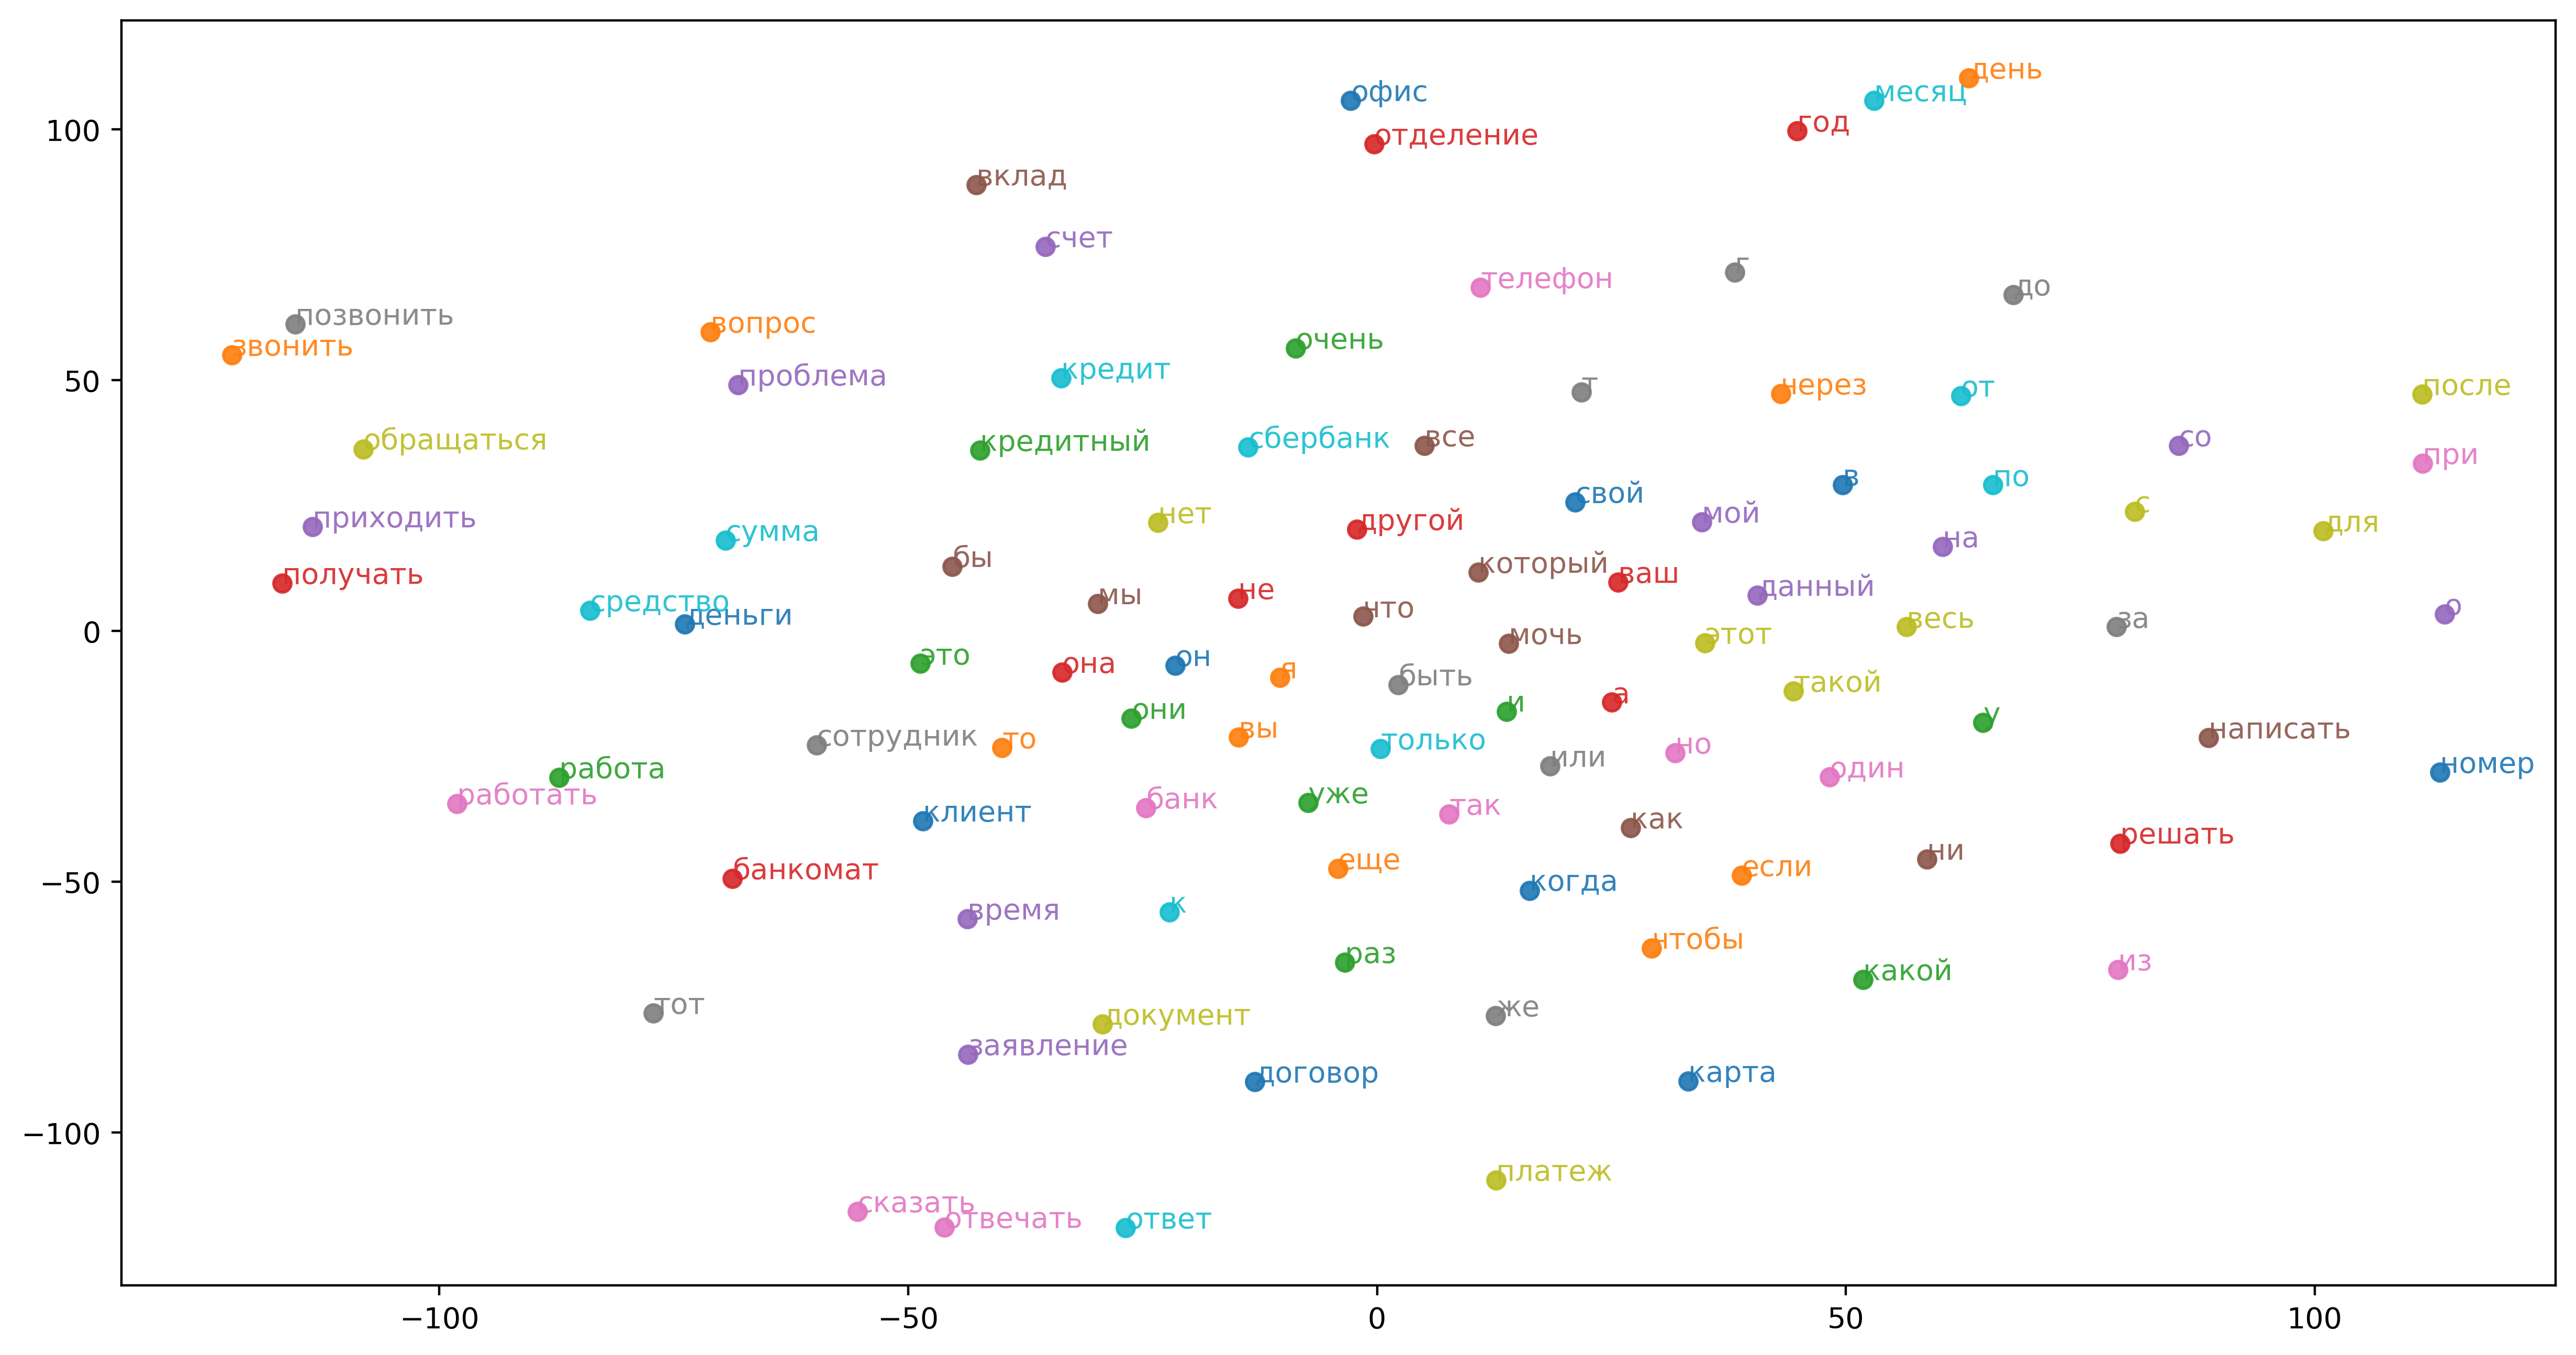

In [106]:
fig = plt.figure(figsize=(15,8), dpi=400)
ax = fig.add_subplot(1,1,1)

for i in range(len(df_w2v)):
    ax.scatter(
        x=df_w2v.iloc[i]["x-tsne"], 
        y=df_w2v.iloc[i]["y-tsne"],
        alpha=0.9,
        c=house_colors[df_w2v.iloc[i]["words"]]
    )
    ax.text(
        x=df_w2v.iloc[i]["x-tsne"],
        y=df_w2v.iloc[i]["y-tsne"],
        s=df_w2v.iloc[i]["words"],
        alpha=0.9,
        color=house_colors[df_w2v.iloc[i]["words"]]
    )
plt.show()

In [ ]:
# ничего не понял...


* задайте координаты для нового пространства следующим образом: одна ось описывает отношение «плохо — хорошо», вторая — «медленно — быстро», и найдите координаты названий банков в этих координатах

берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [107]:
def find_banks(row):
    row = ' '.join(row)
    bank = re.findall(r'\w+банк', row)
    return bank

In [108]:
df['banks'] = df.text.apply(find_banks)

In [109]:
banks_list_ = [i for i in list(df['banks']) if len(i) >= 1]
banks_list = []
for b in banks_list_:
    for bank in b:
        banks_list.append(bank)

banks_set = set(banks_list)

In [110]:
banks_set

{'аальфабанк',
 'абанк',
 'абсолютбанк',
 'автобанк',
 'автовазбанк',
 'автоградбанк',
 'автоторгбанк',
 'адмбанк',
 'айкьюбанк',
 'айманибанк',
 'академхимбанк',
 'акбанк',
 'акбарсбанк',
 'акибанк',
 'активкапиталбанк',
 'алданзолотобанк',
 'алтайбанк',
 'алтайэнергобанк',
 'алтайэнергопромбанк',
 'алтайэноргобанк',
 'алфабанк',
 'альафабанк',
 'альбабанк',
 'альфабанк',
 'альфбанк',
 'анкавбанк',
 'анталбанк',
 'антибанк',
 'арксбанк',
 'арскбанк',
 'атбанк',
 'атласбанк',
 'афльфабанк',
 'байкалбанк',
 'балтбанк',
 'балтинвестбанк',
 'банкбанк',
 'барклайсбанк',
 'башкомснабанк',
 'башкомснаббанк',
 'башкредитбанк',
 'башэкономбанк',
 'ббрбанк',
 'бежбанк',
 'белинвестбанк',
 'бербанк',
 'бинбанк',
 'буйкомбанк',
 'бундесбанк',
 'быстобанк',
 'быстробанк',
 'вашегобанк',
 'веббанк',
 'вечеромсбербанк',
 'витабанк',
 'влбанк',
 'внебанк',
 'внешнебанк',
 'внешпромбанк',
 'внешторбанк',
 'внешторгбанк',
 'внешэкономбанк',
 'внтрибанк',
 'внутребанк',
 'внутрибанк',
 'вокбанк',
 'волг

In [111]:
# Выберем некоторые банки
banks = ['абсолютбанк', 'альфабанк', 'атласбанк',
        'балтинвестбанк', 'втб', 'газпромбанк', 'инвестбанк', 'интеркоммерцбанк',
        'кивибанк', 'металлинвестбанк', 'мтсбанк', 'петрокоммерцбанк',
        'почтобанк', 'псб', 'райфайзенбанк', 'росбанк', 'росгосстрахбанк', 'россельхозбанк',
        'ситибанк', 'совкомбанк', 'тинькофф', 'уралсиббанк']

In [112]:
# Словарь с названиями банков и их эмбеддингами
banks_dict = dict()

for w in banks:
    banks_dict[w] = model_reviews.wv[w]

In [113]:
# Переводим словарь в датафрейм
banks_df = pd.DataFrame(banks_dict).T

In [114]:
colors = plt.cm.tab20.colors

def word2viz_plot(df, words, x_op, y_op, labels=None):
    """Визуализация названий банков на системе координат"""
    df_words = words
    x2, x1 = x_op.split(" - ")
    y2, y1 = y_op.split(" - ")
    x_label = "%s --------> %s" % (x1, x2)
    y_label = "%s --------> %s" % (y1, y2)
    
    word_labels = df_words.index if labels is None else labels

    df_words["x"] = df_words.iloc[:,:300].dot(df.loc[x2] - df.loc[x1])
    df_words["y"] = df_words.iloc[:,:300].dot(df.loc[y2] - df.loc[y1])

    fig = plt.figure(figsize=(12,6), dpi=300)
    ax = fig.add_subplot(1,1,1)

    for i in range(len(df_words)):
        x, y, text = df_words.iloc[i]["x"], df_words.iloc[i]["y"], word_labels[i]
        ax.scatter(x, y, alpha=0.9, c=colors[i%20])
        ax.text(x, y, text, alpha=0.9, color=colors[i%20])

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.show()

    

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

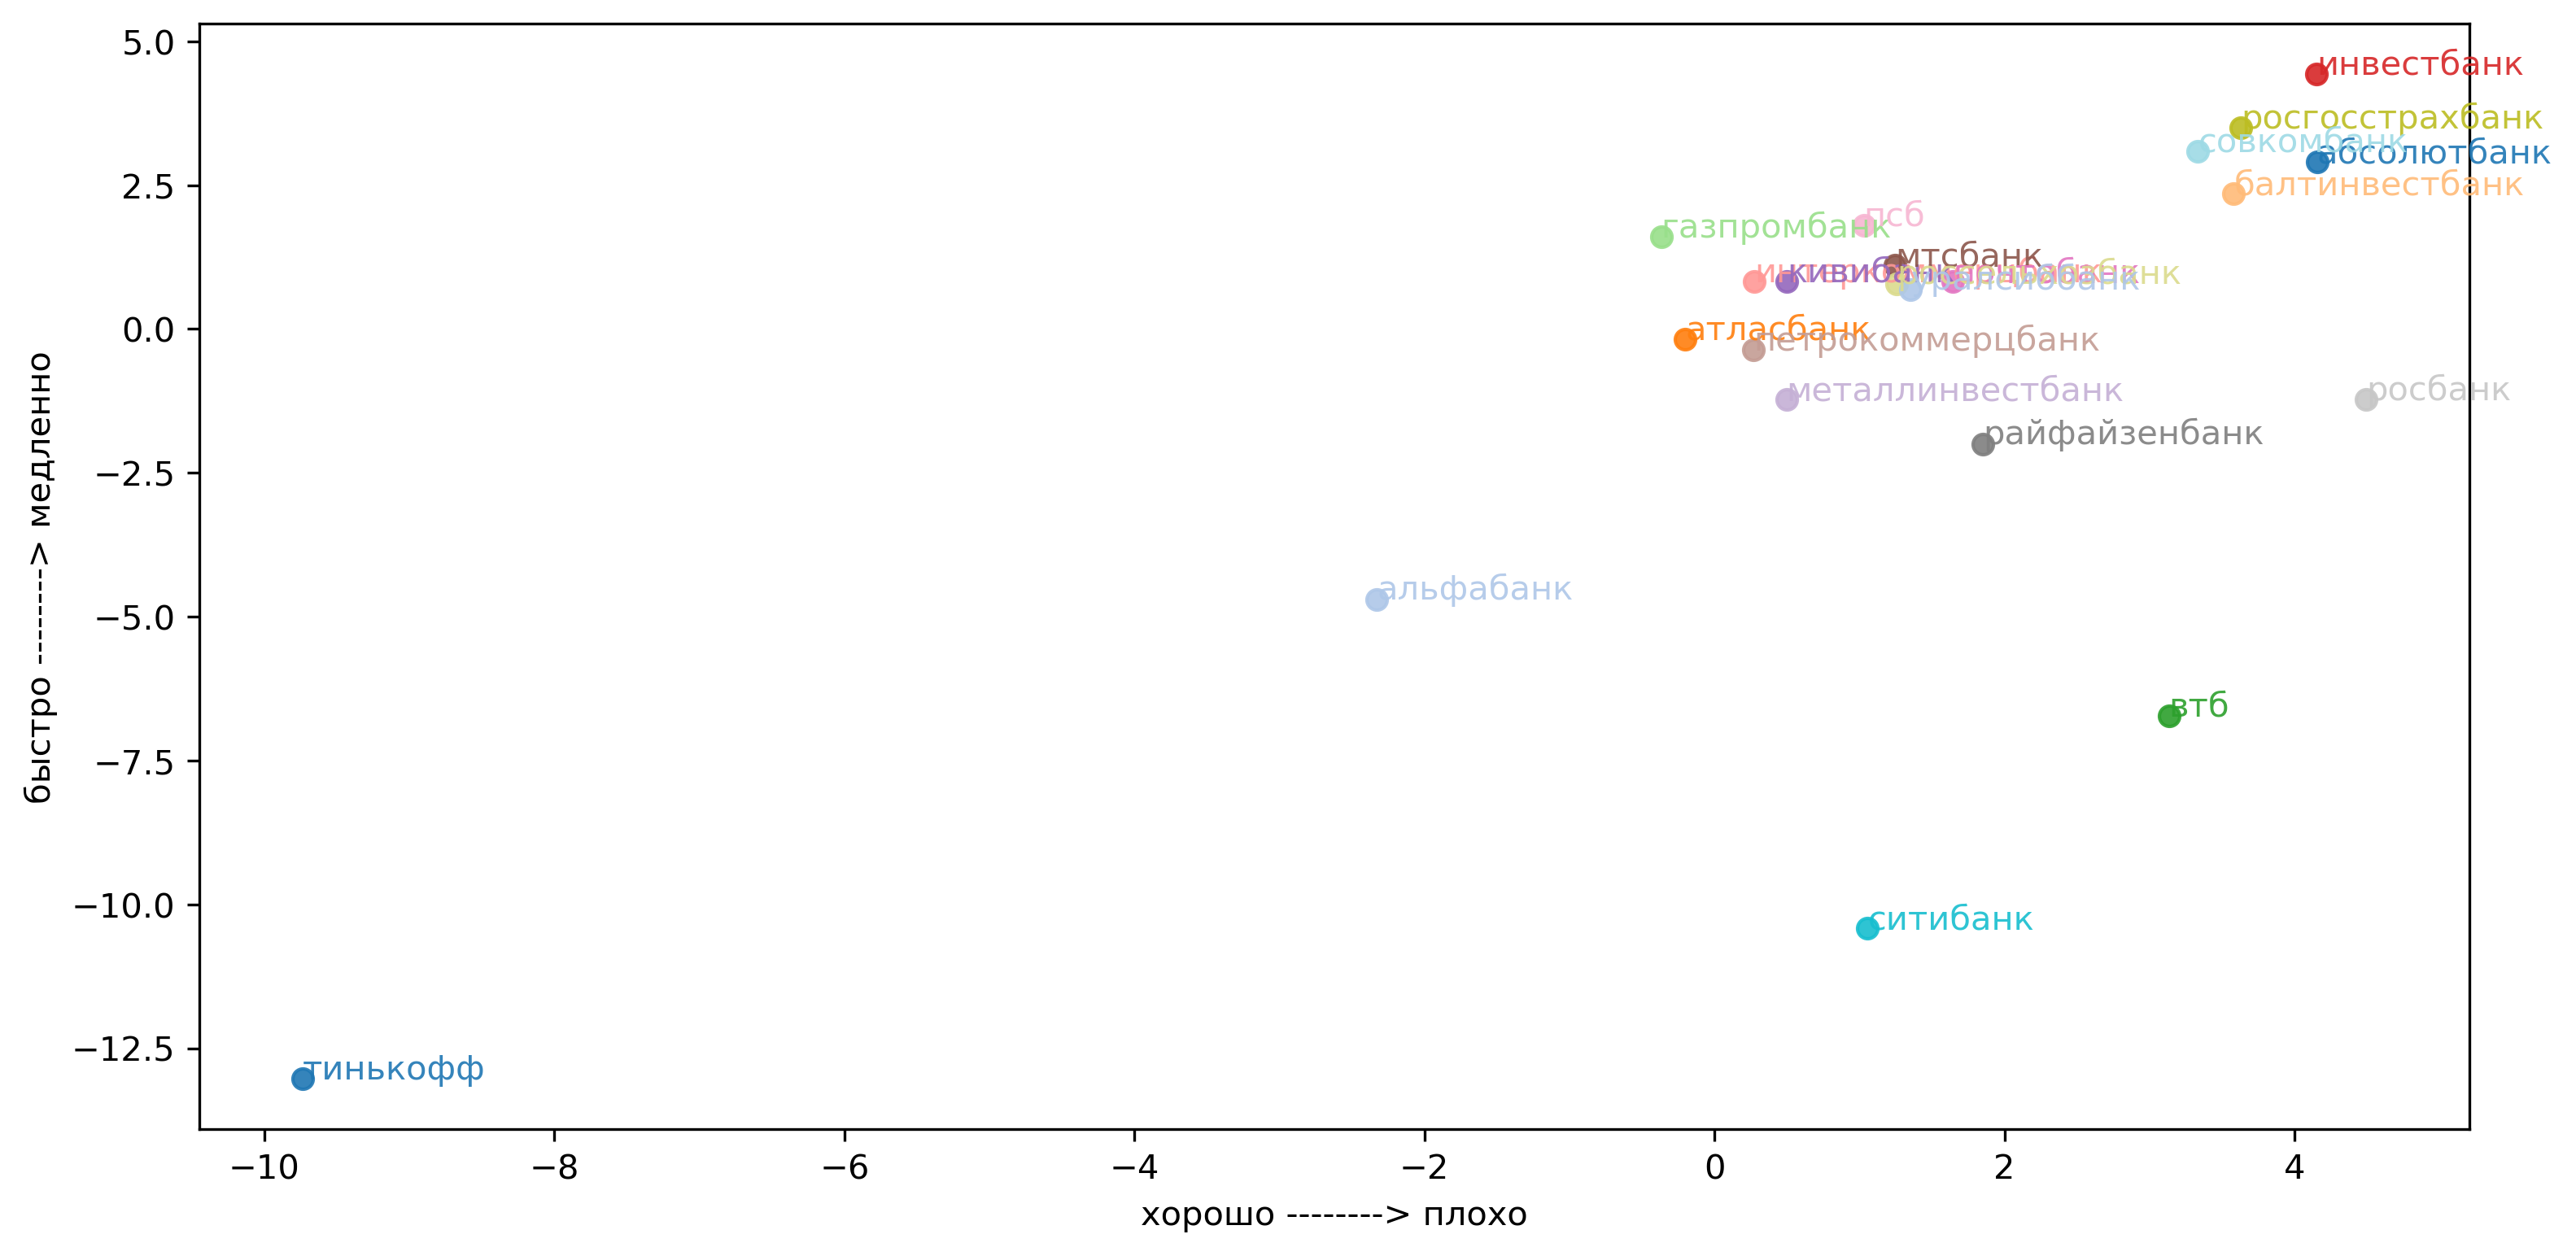

In [115]:
word2viz_plot(w2v_trans, banks_df, "плохо - хорошо", "медленно - быстро", labels=banks)

# Задание 2: распространить метку.

1. Определите 5–8 позитивных слов (например, быстрый, удобный) и 5–8 негативных слов (например, очередь, медленно). Эти слова будут основной будущего оценочного словаря
2. Пусть позитивному классу соответствует метка 1, негативному — -1
3. Пометьте выбранные слова в лексическом графе соответствующими метками
4. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе
5. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 — это и есть искомые оценочные слова

Результат:

Jupyter notebook с предобработанным текстом, аналитикой и выбранными топ-5–8 негативными и позитивными словами

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:

graphlab.label_propagation (graphlab доступен бесплатно по образовательной лицензии)
sklearn.semi_supervised.LabelPropagation
sklearn.semi_supervised.LabelSpreading

1. Определите 5–8 позитивных слов (например, быстрый, удобный) и 5–8 негативных слов (например, очередь, медленно). Эти слова будут основной будущего оценочного словаря

In [39]:
positive_words = ['быстрый', 'нравиться', 'клиентоориентированный', 'положительный', 'спасибо', 'качественный', 'молодец']
negative_words = ['медленный', 'прокуратура', 'полиция', 'очередь', 'обман', 'отвратительный', 'мошенник', 'ущерб']

2. Пусть позитивному классу соответствует метка 1, негативному — -1

In [86]:
all_words = []
dataset = []

for word in positive_words:
    all_words.append(word)
    vec = model_reviews.wv.word_vec(word).tolist()
    vec.append(1)
    dataset.append(vec)
    
for word in negative_words:
    all_words.append(word)
    vec = model_reviews.wv.word_vec(word).tolist()
    vec.append(0)
    dataset.append(vec)    

for word in top_100:
    if word not in positive_words:
        if word not in negative_words:
            all_words.append(word)
            vec = model_reviews.wv.word_vec(word).tolist()
            vec.append(-1)
            dataset.append(vec)

In [87]:
from tqdm import tqdm

In [88]:
ds = {}
for embedding in tqdm(dataset):
    row = embedding
    for i, rows in w2v_trans.iterrows():
        if row[:-1] == rows.to_list():
            ds[i] = row

100%|██████████| 115/115 [01:46<00:00,  1.08it/s]


In [89]:
dsdf = pd.DataFrame.from_dict(ds, orient='index')

3. Пометьте выбранные слова в лексическом графе соответствующими метками
4. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе
5. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 — это и есть искомые оценочные слова

In [51]:
from sklearn.semi_supervised import LabelSpreading

In [94]:
label_spread = LabelSpreading(kernel='knn', alpha=0.8)
label_spread.fit(dsdf.iloc[:, :-1], dsdf.iloc[:, -1])

LabelSpreading(alpha=0.8, kernel='knn')

In [95]:
output_labels = label_spread.transduction_

In [97]:
output_label_array = np.asarray(output_labels)

In [100]:
good_indices = np.where(output_label_array == 1)[0]
bad_indices = np.where(output_label_array == 0)[0]

In [102]:
np.array(all_words)[bad_indices]

array(['медленный', 'прокуратура', 'полиция', 'очередь', 'обман',
       'отвратительный', 'мошенник', 'ущерб', 'я', 'и', 'не', 'на', 'что',
       'банк', 'быть', 'с', 'по', 'карта', 'то', 'это', 'а', 'как', 'за',
       'этот', 'деньги', 'день', 'отделение', 'о', 'который', 'кредит',
       'клиент', 'они', 'она', 'счет', 'мочь', 'сказать', 'же', 'от',
       'через', 'уже', 'получать', 'заявление', 'такой', 'сумма', 'он',
       'раз', 'год', 'т', 'нет', 'только', 'офис', 'какой', 'приходить',
       'после', 'когда', 'банкомат', 'данный', 'телефон', 'позвонить',
       'платеж', 'сбербанк', 'договор', 'звонить', 'написать', 'г',
       'обращаться', 'месяц', 'номер', 'чтобы', 'со', 'ни', 'или',
       'средство'], dtype='<U22')

In [103]:
np.array(all_words)[good_indices]

array(['быстрый', 'нравиться', 'клиентоориентированный', 'положительный',
       'спасибо', 'качественный', 'молодец', 'в', 'мой', 'но', 'к', 'у',
       'так', 'сотрудник', 'весь', 'вы', 'для', 'свой', 'все', 'из', 'до',
       'вопрос', 'время', 'мы', 'при', 'еще', 'другой', 'вклад', 'один',
       'тот', 'ответ', 'если', 'кредитный', 'бы', 'очень', 'решать',
       'проблема', 'работать', 'работа', 'ваш', 'отвечать', 'документ'],
      dtype='<U22')